In [4]:
!unzip compressed.zip
%ls

Archive:  compressed.zip
replace data/freeFall/freeFall9.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: data/freeFall/freeFall9.csv  
replace data/freeFall/freeFall8.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: best_model.h5  compressed.zip  data/  dataframe.csv  data_normalized/  plots/  sample_data/


In [2]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 1.4 MB/s eta 0:00:00


In [31]:
import numpy as np  # linear algebra
import matplotlib.pyplot as plt
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import sklearn.model_selection
import os
import xgboost as xgb
import time
from IPython.display import display

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
pd.set_option('display.precision', 2)

os.makedirs('./data_normalized', exist_ok=True)


def normalize_data_timestamps():
    labels = ['runFall', 'downSit', 'freeFall', 'runSit', 'walkFall', 'walkSit']
    for l in labels:
        i = 0
        for csv_file in glob.glob('data/' + l + '/*.csv'):
            single_df = pd.read_csv(csv_file, sep=';')
            single_df['DiffTimestamp'] = single_df['Timestamp'] - single_df['Timestamp'][0]
            single_df['Series'] = int(''.join(filter(str.isdigit, csv_file)))
            single_df['Label'] = l



            single_df['AccelerationX'] = (single_df['AccelerationX'] - single_df['AccelerationX'].mean()) / single_df['AccelerationX'].std()
            single_df['AccelerationY'] = (single_df['AccelerationY'] - single_df['AccelerationY'].mean()) / single_df['AccelerationY'].std()
            single_df['AccelerationZ'] = (single_df['AccelerationZ'] - single_df['AccelerationZ'].mean()) / single_df['AccelerationZ'].std()

            if i == 0:
                df = single_df
            else:
                df = pd.concat([df, single_df], ignore_index=True)

            i += 1
        df[['Label', 'Series', 'DiffTimestamp', 'DeviceOrientation', 'AccelerationX', 'AccelerationY',
            'AccelerationZ']].to_csv(
            './data_normalized/' + l + '.csv', index=False)


def normalize_data():
    """
    Normalize the data by reading all csv files in the given directory and saving the normalized data to csv files.

    Parameters:
    ----------
    None

    Returns:
    -------
    None
    """
    labels = ['runFall', 'downSit', 'freeFall', 'runSit', 'walkFall', 'walkSit']
    for l in labels:
        # read all csv files in the directory '/kaggle_data/' + l, delimit by ';'
        df = pd.concat([pd.read_csv(f, sep=';') for f in glob.glob('data/' + l + '/*.csv')], ignore_index=True)
        # assign l to to df column 'Label'
        df['Label'] = l
        df
        # save columns 'DeviceOrientation', 'AccelerationX','AccelerationY', 'AccelerationZ', 'Label' to csv
        df[['DeviceOrientation', 'AccelerationX', 'AccelerationY', 'AccelerationZ', 'Label']].to_csv(
            './data_normalized/' + l + '.csv', index=False)


def read_data(fft):
    df = pd.concat([pd.read_csv(f) for f in glob.glob('./data_normalized/*.csv')], ignore_index=True)
    columns = ['DeviceOrientation', 'AccelerationX', 'AccelerationY', 'AccelerationZ', 'Label']
    if fft:
        for c in ['AccelerationX', 'AccelerationY', 'AccelerationZ']:
            df[c + '_fft'] = np.abs(np.fft.fft(df[c]))

    return df


def plot_dataset(df, series=1):
    for l in labels:
        plt.figure()
        t = df.loc[df['Label'] == l].loc[df['Series'] == 1]['DiffTimestamp']
        X = df.loc[df['Label'] == l].loc[df['Series'] == 1]['AccelerationX']
        Y = df.loc[df['Label'] == l].loc[df['Series'] == 1]['AccelerationY']
        Z = df.loc[df['Label'] == l].loc[df['Series'] == 1]['AccelerationZ']
        plt.plot(t, X, linewidth=2, label='AccelerationX')
        plt.plot(t, Y, linewidth=2, label='AccelerationY')
        plt.plot(t, Z, linewidth=2, label='AccelerationZ')
        #plt.plot(t, np.sqrt(X ** 2 + Y ** 2 + Z ** 2), linewidth=2, label='Net acceleration')
        plt.legend()
        plt.xlabel('Timestamp (s)')
        plt.ylabel('Acceleration')
        plt.savefig('plots/' + l + 'series_' + str(series) + '_Acceleration.png')


def plot_dataset_fft(df, series=1):
    for l in labels:
        plt.figure()

        X = df.loc[df['Label'] == l].loc[df['Series'] == 1]['AccelerationX_fft']
        Y = df.loc[df['Label'] == l].loc[df['Series'] == 1]['AccelerationY_fft']
        Z = df.loc[df['Label'] == l].loc[df['Series'] == 1]['AccelerationZ_fft']
        plt.plot(X, linewidth=2, label='FFT AccelerationX')
        plt.plot(Y, linewidth=2, label='FFT AccelerationY')
        plt.plot(Z, linewidth=2, label='FFT AccelerationZ')
        # plt.plot(np.sqrt(X ** 2 + Y ** 2 + Z ** 2), linewidth=2, label='Net FFT acceleration')
        plt.legend()
        plt.ylabel('Acceleration')
        plt.savefig('plots/' + l + 'series_' + str(series) + '_Acceleration_fft.png')


def convert_categorical_to_numerical(df):
    df_new = df
    # convert categorical data to numerical data
    df_new['Label'] = df_new['Label'].astype('category')
    df_new['Label'] = df_new['Label'].cat.codes
    # df.head()

    # convert column `DeviceOrientation` to numerical data
    df_new['DeviceOrientation'] = df_new['DeviceOrientation'].astype('category')
    df_new['DeviceOrientation'] = df_new['DeviceOrientation'].cat.codes
    df_new.head()
    return df_new


def split_data(df):
    df_train = df[~df['Series'].isin([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])]
    df_test = df[df['Series'].isin([1, 2, 3, 4, 5, 6, 7, 8 , 9, 10, 11])]
    print(f'Training size in percent: {len(df_train) / len(df) * 100}')
    print(f'Testing size in percent: {len(df_test)/len(df) * 100}')
    x_train = df_train.drop(labels=['Label'], axis=1)
    y_train =df_train["Label"]
    x_test =df_test.drop(labels=['Label'], axis=1)
    y_test = df_test["Label"]

    #x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y, test_size=1-split)
    return x_train, x_test, y_train, y_test


def train_model(x_train, y_train, x_test, y_test):
    from tensorflow import keras
    from keras.layers import Dense
    from keras.models import Sequential
    from keras.layers import Flatten
    from keras.layers import Dropout
    from keras.layers import LSTM
    from keras.callbacks import EarlyStopping
    from tensorflow.keras.callbacks import ModelCheckpoint
    from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Dropout


    model = Sequential()
    # Assuming x_train.shape = (num_samples, sequence_length, num_features)

    model = Sequential()

    model.add(LSTM(32, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(16,  activation='tanh', return_sequences=True))
    model.add(LSTM(8,  activation='tanh', return_sequences=True))
    model.add(LSTM(16,  activation='tanh', return_sequences=True))
    model.add(LSTM(32,  activation='tanh'))
    model.add(Dense(len(labels), activation='softmax'))

    """
    model.add(LSTM(256, dropout=0.05, recurrent_dropout=0.01, activation='tanh', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(LSTM(64, dropout=0.05, recurrent_dropout=0.01, activation='tanh', return_sequences=True))
    model.add(LSTM(16, dropout=0.05, recurrent_dropout=0.01, activation='tanh', return_sequences=True))
    model.add(LSTM(64, dropout=0.05, recurrent_dropout=0.01, activation='tanh', return_sequences=True))
    model.add(LSTM(256, dropout=0.05, recurrent_dropout=0.01, activation='tanh'))
    model.add(Dense(len(labels), activation='softmax'))



    # First, add convolutional layers for feature extraction
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    # Next, add LSTM layers for sequence processing
    model.add(LSTM(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(labels), activation='softmax'))



    model.add(LSTM(256, activation='tanh', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(LSTM(128, dropout=0.05, activation='tanh', return_sequences=True))
    model.add(LSTM(64,  activation='tanh', return_sequences=True))
    model.add(LSTM(128, dropout=0.05, activation='tanh', return_sequences=True))
    model.add(LSTM(256,  activation='tanh'))


    model.add(LSTM(256, dropout=0.1, recurrent_dropout=0.1, activation='tanh', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(LSTM(128, dropout=0.1, recurrent_dropout=0.1, activation='tanh', return_sequences=True))
    model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, activation='tanh', return_sequences=True))
    model.add(LSTM(32, dropout=0.1, recurrent_dropout=0.1, activation='tanh', return_sequences=True))
    model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1, activation='tanh', return_sequences=True))
    model.add(LSTM(128, dropout=0.1, recurrent_dropout=0.1, activation='tanh', return_sequences=True))
    model.add(LSTM(256, dropout=0.1, recurrent_dropout=0.1, activation='tanh'))
    model.add(Dense(len(labels), activation='softmax'))

    model.add(Dense(512,  activation='tanh', input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(128,  activation='relu'))
    model.add(Dense(32,  activation='relu'))
    model.add(Dense(128,  activation='relu'))
    model.add(Dense(512,  activation='relu'))
    model.add(Dense(len(labels), activation='softmax'))
    """

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model2.h5', monitor='val_loss', save_best_only=True)]


    history = model.fit(x_train,
                        y_train,
                        epochs=100,
                        batch_size=8,
                        validation_data=(x_test, y_test),
                        callbacks=callbacks)

    model.load_weights('best_model2.h5')

    test_loss, test_acc = model.evaluate(x_test, y_test)
    print('Test accuracy:', test_acc)
    return model, history


from kerastuner.tuners import BayesianOptimization

def build_model(hp):
    import tensorflow as tf
    from tensorflow import keras
    from keras.layers import Dense
    from keras.models import Sequential
    from keras.layers import Flatten
    from keras.layers import Dropout
    from keras.layers import LSTM
    model = Sequential()

    model.add(LSTM(units=hp.Choice('units', values=[16, 32, 64, 128]), activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=hp.Choice('units', values=[16, 32, 64, 128]),  activation='tanh', return_sequences=True))
    model.add(LSTM(units=hp.Choice('units', values=[16, 32, 64, 128]),  activation='tanh', return_sequences=True))
    model.add(LSTM(units=hp.Choice('units', values=[16, 32, 64, 128]),  activation='tanh'))
    model.add(Dense(len(labels), activation='softmax'))

    #model.compile(optimizer='adam',
    #              loss='sparse_categorical_crossentropy',
    #              metrics=['accuracy'])


    model.compile(optimizer=tf.keras.optimizers.Adam(
              hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model


    #https://arxiv.org/abs/1611.06455
def create_sequences(data, sequence_length, target_column_index):
    pd.options.mode.chained_assignment = None
    X, y = [], []
    series_values = np.sort(data['Series'].unique())
    sequence_lengths = []
    for series_value in series_values:
        data_sequence = data[data['Series'].isin([series_value])]
        label_values = np.sort(data_sequence['Label'].unique())
        for label_value in label_values:
            data_sequence_label = data_sequence[data_sequence['Label'].isin([label_value])]


            data_sequence_label['AccelerationX'] = (data_sequence_label['AccelerationX'] - data_sequence_label['AccelerationX'].mean()) / data_sequence_label['AccelerationX'].std()
            data_sequence_label['AccelerationY'] = (data_sequence_label['AccelerationY'] - data_sequence_label['AccelerationY'].mean()) / data_sequence_label['AccelerationY'].std()
            data_sequence_label['AccelerationZ'] = (data_sequence_label['AccelerationZ'] - data_sequence_label['AccelerationZ'].mean()) / data_sequence_label['AccelerationZ'].std()

            sequence_lengths.append(len(data_sequence_label))
            #print(series_value)
            #print(sequence_length)
            X.append(data_sequence_label[['DiffTimestamp', 'DeviceOrientation',
           'AccelerationX', 'AccelerationY', 'AccelerationZ']][-145:])
            y.append(data_sequence_label['Label'].unique())


    n = 5
    return np.array(X), np.array(y), n


def optimize_network(hp):
    import tensorflow as tf

    from tensorflow import keras
    from keras.callbacks import EarlyStopping
    from tensorflow.keras.callbacks import ModelCheckpoint
    from keras.models import Model
    from keras.layers import Dense
    from keras.models import Sequential
    from keras.layers import Flatten
    from keras.layers import Dropout
    from keras.layers import LSTM
    from keras.layers import Convolution1D, BatchNormalization, MaxPool1D
    from tensorflow.keras.layers import Input


    im_shape=(X_train.shape[1], X_train.shape[2])
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')

    # num_of_neurons = 64
    num_of_neurons = hp.Choice('n_neurons', values=[16, 32, 64, 128, 256])
    # num_of_neurons = 256
    # num_of_neurons = 128

    num_of_filters_1 = hp.Choice('n_filter1', values=[1, 2, 3, 4, 5, 6, 7, 8])
    num_of_filters_2 = hp.Choice('n_filter2', values=[1, 2, 3, 4, 5, 6, 7, 8])
    num_of_filters_3 = hp.Choice('n_filter3', values=[1, 2, 3, 4, 5, 6, 7, 8])
    num_of_filters_4 = hp.Choice('n_filter4', values=[1, 2, 3, 4, 5, 6, 7, 8])
    dropout_rate = hp.Choice('n_dropout', values=[0.3, 0.5])

    num_dense_1 = hp.Choice('n_dense1', values=[16, 32, 64, 128])
    num_dense_2 = hp.Choice('n_dense2', values=[16, 32, 64, 128])
    num_dense_3 = hp.Choice('n_dense3', values=[16, 32, 64, 128])

    conv1_1=Convolution1D(num_of_neurons, (num_of_filters_1), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)

    conv2_1=Convolution1D(num_of_neurons, (num_of_filters_2), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)

    conv3_1=Convolution1D(num_of_neurons, (num_of_filters_3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)

    pool3 = Dropout(dropout_rate)(pool3)

    conv4_1 = Convolution1D(num_of_neurons, (num_of_filters_3), activation='relu')(pool3)  # New convolutional layer
    conv4_1 = BatchNormalization()(conv4_1)
    pool4 = MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv4_1)

    pool4 = Dropout(dropout_rate)(pool4)

    flatten = Flatten()(pool4)
    # flatten = Flatten()(pool3)

    dense_end1 = Dense(num_dense_1, activation='relu')(flatten)
    # dense_end1 = Dense(128, activation='relu')(flatten)

    pool3 = Dropout(dropout_rate)(dense_end1)

    dense_end2 = Dense(num_dense_2, activation='relu')(pool3)

    # dense_end2 = Dense(64, activation='relu')(dense_end1)
    # dense_end2 = Dense(32, activation='relu')(dense_end1)

    dense_end3 = Dense(num_dense_3, activation='relu')(dense_end2)

    # main_output = Dense(6, activation='softmax', name='main_output')(dense_end3)
    main_output = Dense(len(labels), activation='softmax', name='main_output')(dense_end3)


    model = Model(inputs= inputs_cnn, outputs=main_output)

    # custom_adam = Adam(learning_rate=0.0001)

    # model.compile(optimizer=custom_adam, loss='categorical_crossentropy',metrics = ['accuracy'])
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])

    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    return model, callbacks


def network(X_train,y_train,X_test,y_test):
    import tensorflow as tf

    from tensorflow import keras
    from keras.callbacks import EarlyStopping
    from tensorflow.keras.callbacks import ModelCheckpoint
    from keras.models import Model
    from keras.layers import Dense
    from keras.models import Sequential
    from keras.layers import Flatten
    from keras.layers import Dropout
    from keras.layers import LSTM
    from keras.layers import Convolution1D, BatchNormalization, MaxPool1D
    from tensorflow.keras.layers import Input


    im_shape=(X_train.shape[1], X_train.shape[2])
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')

    # num_of_neurons = 64
    num_of_neurons = 32
    # num_of_neurons = 256
    # num_of_neurons = 128

    num_of_filters_1 = 5
    num_of_filters_2 = 3
    num_of_filters_3 = 3
    num_of_filters_4 = 3

    #num_of_neurons = 512
    #num_of_filters_1 = 3
    #num_of_filters_2 = 1
    #num_of_filters_3 = 2
    #num_of_filters_4 = 3
    dropout_rate = 0.5

    conv1_1=Convolution1D(num_of_neurons, (num_of_filters_1), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)

    conv2_1=Convolution1D(num_of_neurons, (num_of_filters_2), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)

    conv3_1=Convolution1D(num_of_neurons, (num_of_filters_3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)

    pool3 = Dropout(dropout_rate)(pool3)

    conv4_1 = Convolution1D(num_of_neurons, (num_of_filters_4), activation='relu')(pool3)  # New convolutional layer
    conv4_1 = BatchNormalization()(conv4_1)
    pool4 = MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv4_1)

    pool4 = Dropout(dropout_rate)(pool4)

    flatten = Flatten()(pool4)
    # flatten = Flatten()(pool3)

    dense_end1 = Dense(64, activation='relu')(flatten)
    # dense_end1 = Dense(128, activation='relu')(flatten)

    pool3 = Dropout(dropout_rate)(dense_end1)

    dense_end2 = Dense(32, activation='relu')(pool3)

    # dense_end2 = Dense(64, activation='relu')(dense_end1)
    # dense_end2 = Dense(32, activation='relu')(dense_end1)

    dense_end3 = Dense(16, activation='relu')(dense_end2)

    # main_output = Dense(6, activation='softmax', name='main_output')(dense_end3)
    main_output = Dense(len(labels), activation='softmax', name='main_output')(dense_end3)


    model = Model(inputs= inputs_cnn, outputs=main_output)

    # custom_adam = Adam(learning_rate=0.0001)

    # model.compile(optimizer=custom_adam, loss='categorical_crossentropy',metrics = ['accuracy'])
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])

    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model2.h5', monitor='val_loss', save_best_only=True)]

    # history=model.fit(X_train, y_train,epochs=40,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    # history=model.fit(X_train, y_train,epochs=80, batch_size=8,validation_data=(X_test,y_test))
    #model.load_weights('CNN_best_model_weights.h5')

    history=model.fit(X_train, y_train,epochs=400, batch_size=8,validation_data=(X_test,y_test), callbacks=callbacks)
    # history=model.fit(X_train, y_train,epochs=1280, batch_size=8,validation_data=(X_test,y_test))
    model.load_weights('best_model2.h5')
    return(model,history)



def network_lstm(X_train,y_train,X_test,y_test):
    import tensorflow as tf

    from tensorflow import keras
    from keras.callbacks import EarlyStopping
    from tensorflow.keras.callbacks import ModelCheckpoint
    from keras.models import Model
    from keras.layers import Dense
    from keras.models import Sequential
    from keras.layers import Flatten
    from keras.layers import Dropout
    from keras.layers import LSTM, Conv1D, MaxPooling1D
    from keras.layers import Convolution1D, BatchNormalization, MaxPool1D
    from tensorflow.keras.layers import Input


    input_shape=(X_train.shape[1], X_train.shape[2])
    # input_shape=Input(shape=(im_shape), name='inputs_cnn')

    num_of_neurons = 64
    # num_of_neurons = 256
    # num_of_neurons = 128

    model = Sequential()

    # First, add convolutional layers for feature extraction
    model.add(Conv1D(filters=6, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))


    model.add(Conv1D(filters=6, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    model.add(Dropout(0.4))

    # model.add(Flatten())

    # model.add(Conv1D(filters=3, kernel_size=3, activation='relu'))
    # model.add(BatchNormalization())
    # model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(filters=3, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))

    # Next, add LSTM layers for sequence processing
    model.add(LSTM(16, activation='relu'))
    # model.add(LSTM(32, activation='relu'))
    model.add(Dropout(0.4))

    # model.add(Dense(16, activation='softmax'))  # Use 'softmax' for multi-class classification

    # Output layer for classification
    model.add(Dense(6, activation='softmax'))  # Use 'softmax' for multi-class classification

    # main_output = Dense(len(labels), activation='softmax', name='main_output')(dense_end3)


    # model = Model(inputs= inputs_cnn, outputs=main_output)

    # custom_adam = Adam(learning_rate=0.0001)

    # model.compile(optimizer=custom_adam, loss='categorical_crossentropy',metrics = ['accuracy'])
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])

    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    # model.load_weights('CNN_LSTM_model_1.h5')
    # history=model.fit(X_train, y_train,epochs=40,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    history=model.fit(X_train, y_train,epochs=800, batch_size=8,validation_data=(X_test,y_test))
    # model.load_weights('best_model.h5')
    return(model,history)


labels = ['runFall', 'downSit', 'freeFall', 'runSit', 'walkFall', 'walkSit']
dataset = read_data(fft=True)
train_dataset = convert_categorical_to_numerical(df=dataset)

train_dataset[:10].to_csv('dataframe.csv', index=False)

sequence_length = 5
target_column_index = train_dataset.columns.get_loc('Label')

X, y, n_features = create_sequences(train_dataset, sequence_length, target_column_index)

np.random.seed(42)
# Generate a permutation of indices and apply it to both arrays
permutation = np.random.permutation(len(X))
X = X[permutation]
y = y[permutation]

train_size_1 = int(len(X) * 0.7)
train_size_2 = int(len(X) * 0.7)
X_train, X_test = X[:train_size_1], X[train_size_2:]
y_train, y_test = y[:train_size_1], y[train_size_2:]

from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))



In [32]:
import time
# Start time
start_time = time.time()

model,history=network_lstm(X_train,y_train,X_test,y_test)




"""
tuner = BayesianOptimization(optimize_network,
                             objective='val_accuracy',
                             max_trials=50,
                             executions_per_trial=2,
                             directory='cnn4',
                             project_name='bayesian_optim')

tuner.search(X_train, y_train,
             epochs=100,
             batch_size=8,
             validation_data=(X_test, y_test))
"""
#model, history = train_model(X_train, y_train, X_test, y_test)

# End time
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time

Epoch 1/800
18/18 [==============================] - 6s 75ms/step - loss: 1.7897 - accuracy: 0.2183 - val_loss: 1.8098 - val_accuracy: 0.0984
Epoch 2/800
18/18 [==============================] - 1s 39ms/step - loss: 1.7128 - accuracy: 0.2817 - val_loss: 1.7766 - val_accuracy: 0.3279
Epoch 3/800
18/18 [==============================] - 1s 39ms/step - loss: 1.6967 - accuracy: 0.2746 - val_loss: 1.7556 - val_accuracy: 0.3607
Epoch 4/800
18/18 [==============================] - 1s 36ms/step - loss: 1.6379 - accuracy: 0.3310 - val_loss: 1.7197 - val_accuracy: 0.3279
Epoch 5/800
18/18 [==============================] - 1s 39ms/step - loss: 1.6612 - accuracy: 0.3873 - val_loss: 1.6978 - val_accuracy: 0.3115
Epoch 6/800
18/18 [==============================] - 1s 35ms/step - loss: 1.5966 - accuracy: 0.3380 - val_loss: 1.6859 - val_accuracy: 0.3443
Epoch 7/800
18/18 [==============================] - 1s 37ms/step - loss: 1.5774 - accuracy: 0.3380 - val_loss: 1.6437 - val_accuracy: 0.2951
Epoch 

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print(elapsed_time)


from tensorflow.keras.models import load_model

# Load the saved model
#model2 = load_model('best_model.h5')

y_prediction = model.predict(X_test)


y_pred = np.where(y_prediction == np.max(y_prediction, axis=1, keepdims=True), 1, 0)


def transform_array(arr):
    """
    Transform the array so that if the 1 is in the first, third, or fifth position,
    it returns 1, otherwise returns 0.
    """
    transformed = []
    for row in arr:
        # Check if 1 is in the first, third or fifth position
        if row[0] == 1 or row[2] == 1 or row[4] == 1:
            transformed.append(1)
        else:
            transformed.append(0)
    return transformed

def transform_to_one_hot(arr, num_classes):
    """
    Transform the array to one-hot encoding based on the number of classes.
    Each element in the input array is an integer that represents the class index.
    """
    # Initialize an array of zeros with the shape (len(arr), num_classes)
    one_hot = np.zeros((len(arr), num_classes))

    # Set the appropriate element to 1 for each row based on the class index
    for i, class_index in enumerate(arr):
        one_hot[i, class_index] = 1

    return one_hot


#y_test = transform_to_one_hot(y_test, 6)


y_pred_bin = transform_array(y_pred)
y_test_bin = transform_array(y_test)

accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")

accuracy = accuracy_score(y_test_bin, y_pred_bin)

print(f"BinAccuracy: {accuracy}")

# Calculate Precision, Recall, and F1 Score
precision = precision_score(y_test_bin, y_pred_bin)
recall = recall_score(y_test_bin, y_pred_bin)
f1 = f1_score(y_test_bin, y_pred_bin)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
"""
# Calculate Precision, Recall, and F1 Score with macro averaging
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')
f1_macro = f1_score(y_test, y_pred, average='macro')

print(f"Macro-average Precision: {precision_macro}")
print(f"Macro-average Recall: {recall_macro}")
print(f"Macro-average F1 Score: {f1_macro}")

"""

144.518239736557
2/2 [==============================] - 1s 131ms/step
Accuracy: 0.8360655737704918
BinAccuracy: 0.8852459016393442
Precision: 0.8780487804878049
Recall: 0.9473684210526315
F1 Score: 0.9113924050632912


'\n# Calculate Precision, Recall, and F1 Score with macro averaging\nprecision_macro = precision_score(y_test, y_pred, average=\'macro\')\nrecall_macro = recall_score(y_test, y_pred, average=\'macro\')\nf1_macro = f1_score(y_test, y_pred, average=\'macro\')\n\nprint(f"Macro-average Precision: {precision_macro}")\nprint(f"Macro-average Recall: {recall_macro}")\nprint(f"Macro-average F1 Score: {f1_macro}")\n\n'

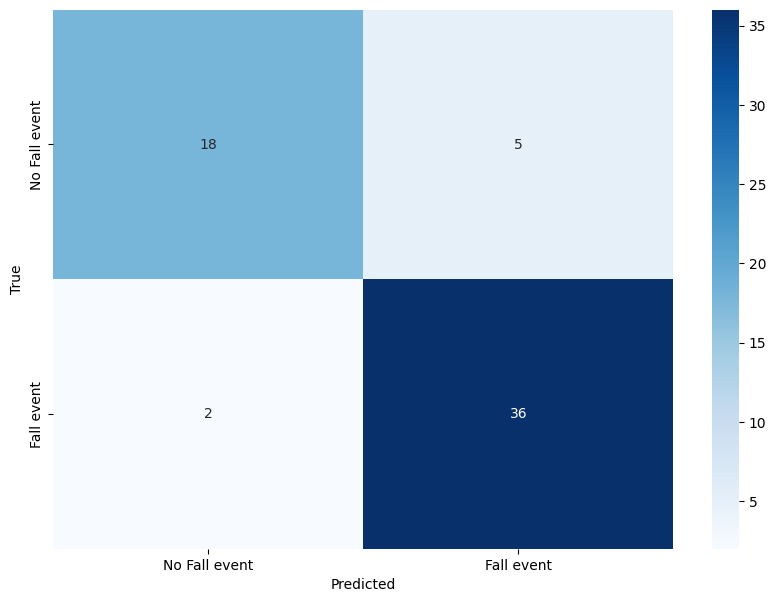

In [15]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_bin, y_pred_bin)

import matplotlib.pyplot as plt
import seaborn as sns  # for a nicer-looking matrix

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
# Set the tick labels
plt.xticks(ticks=[0.5, 1.5], labels=['No Fall event', 'Fall event'])
plt.yticks(ticks=[0.5, 1.5], labels=['No Fall event', 'Fall event'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


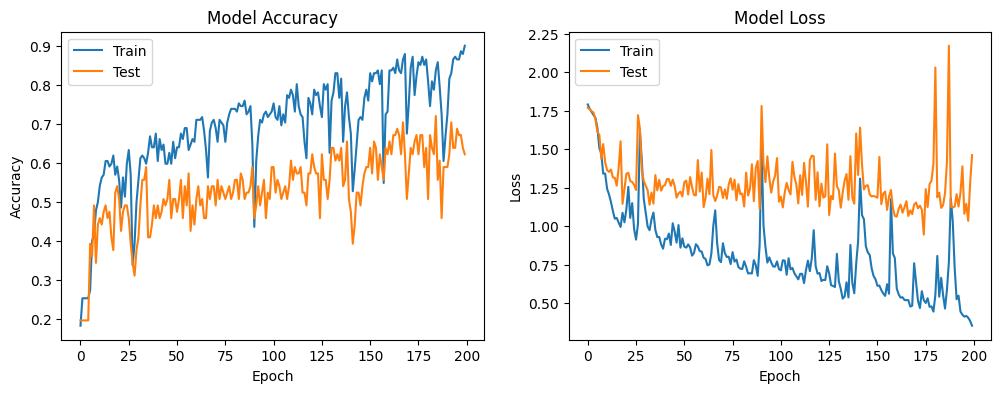

In [13]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()